## Setup

In [42]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [43]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
#task = 'TurnOnLight'
task = 'PressButton'
path = data_root / task / 'demos'

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))


SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
    mask=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.uint8, is_shared=False),
    object_poses=TensorDict(
        fields={
            obj000: Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
            obj001: Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
            obj002: Tensor(shape=torch.Size([7]), device=cpu, dtype

In [45]:
gt_pose_config = {
    #'indeces': [1,2,3,4],
}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'front',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [46]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses', 'object_states'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([99, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('wrist',),
                batch_size=torch.Size([99]),
                device=None,
                is_shared=False),
            wrist: SingleCamObservation(
                depth=Tensor(shape=torch.Size([99, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([99, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([99, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([99, 3, 256, 256]), device=cpu, dtype=to

In [47]:
tag="no_time"

tpgmm_config = TPGMMConfig(
    n_components=20,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False, #Use rotation aswell?

    add_gripper_action=True,

    reg_shrink=1e-2,
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,

    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,

    trans_cov_mask_t_pos_corr = False,

    em_steps=1,

    fix_first_component=True,
    fix_last_component=True,

    reg_init_diag=5e-4,  # 5

    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.5,
    use_bic=False, #Does prune segmentation

    drop_redundant_frames=False,
)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    velocity_threshold=0.01,

    repeat_final_step=0,
    repeat_first_step=0,

    components_prop_to_len=True,

    min_n_components=2,
    max_idx_distance=6,
)

cascade_config = CascadeConfig(
    kl_keep_time_dim=True,
    kl_keep_rotation_dim=False,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)


In [48]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-04-01 14:04:44.524 | INFO     |    Fitting AutoTPGMM
2025-04-01 14:04:44.525 | INFO     |    Segmenting trajectories


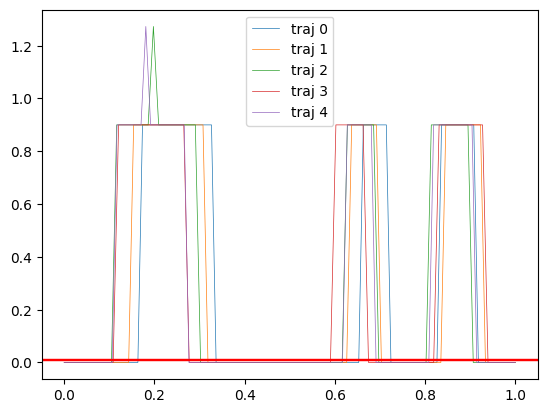

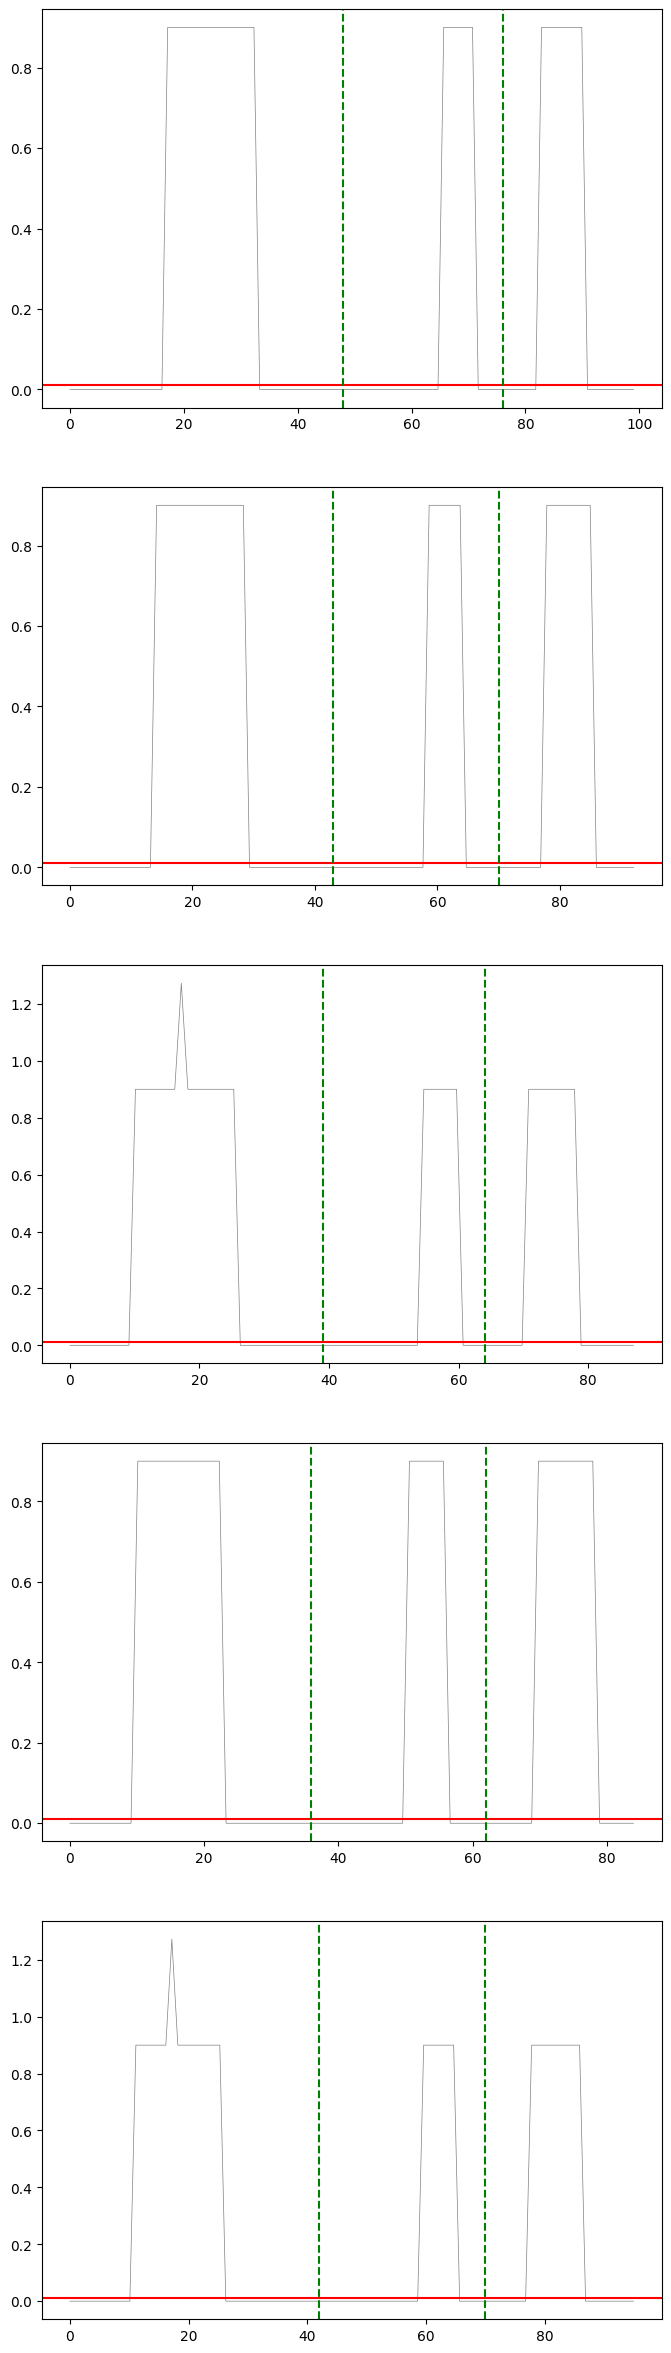

2025-04-01 14:04:45.354 | INFO     |    Creating segement of demos.
2025-04-01 14:04:45.358 | INFO     |    Creating segement of demos.
2025-04-01 14:04:45.362 | INFO     |    Creating segement of demos.
2025-04-01 14:04:45.366 | INFO     |    ... created 3 segments
2025-04-01 14:04:45.366 | INFO     |      Fitting candidate frame 1/10
2025-04-01 14:04:45.367 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2025-04-01 14:04:45.768 | INFO     |      Fitting candidate frame 2/10
2025-04-01 14:04:45.768 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2025-04-01 14:04:46.077 | INFO     |      Fitting candidate frame 3/10
2025-04-01 14:04:46.078 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2025-04-01 14:04:46.368 | INFO     |      Fitting candidate frame 4/10
2025-04-01 14:04:46.369 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2025-04-01 14:04:46.699 | INFO     |      Fitting candidate frame 5/10
2025-04-01 14:04:46.700 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2025-04-01 14:04:47.068 | INFO     |      Fitting candidate frame 6/10
2025-04-01 14:04:47.069 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2025-04-01 14:04:47.380 | INFO     |      Fitting candidate frame 7/10
2025-04-01 14:04:47.380 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2025-04-01 14:04:47.656 | INFO     |      Fitting candidate frame 8/10
2025-04-01 14:04:47.656 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2025-04-01 14:04:48.035 | INFO     |      Fitting candidate frame 9/10
2025-04-01 14:04:48.036 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2025-04-01 14:04:48.505 | INFO     |      Fitting candidate frame 10/10
2025-04-01 14:04:48.505 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2025-04-01 14:04:48.985 | INFO     |    Creating partial frame view of demos.
2025-04-01 14:04:48.991 | INFO     |      Fitting candidate frame 1/10
2025-04-01 14:04:48.991 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-01 14:04:49.187 | INFO     |      Fitting candidate frame 2/10
2025-04-01 14:04:49.187 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-01 14:04:49.337 | INFO     |      Fitting candidate frame 3/10
2025-04-01 14:04:49.337 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-01 14:04:49.520 | INFO     |      Fitting candidate frame 4/10
2025-04-01 14:04:49.520 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-01 14:04:49.714 | INFO     |      Fitting candidate frame 5/10
2025-04-01 14:04:49.715 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-01 14:04:49.874 | INFO     |      Fitting candidate frame 6/10
2025-04-01 14:04:49.875 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-01 14:04:50.023 | INFO     |      Fitting candidate frame 7/10
2025-04-01 14:04:50.024 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-01 14:04:50.185 | INFO     |      Fitting candidate frame 8/10
2025-04-01 14:04:50.186 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-01 14:04:50.482 | INFO     |      Fitting candidate frame 9/10
2025-04-01 14:04:50.482 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-01 14:04:50.721 | INFO     |      Fitting candidate frame 10/10
2025-04-01 14:04:50.721 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-01 14:04:50.966 | INFO     |    Creating partial frame view of demos.
2025-04-01 14:04:51.011 | INFO     |      Fitting candidate frame 1/10
2025-04-01 14:04:51.012 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-01 14:04:51.191 | INFO     |      Fitting candidate frame 2/10
2025-04-01 14:04:51.191 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-01 14:04:51.346 | INFO     |      Fitting candidate frame 3/10
2025-04-01 14:04:51.346 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-01 14:04:51.514 | INFO     |      Fitting candidate frame 4/10
2025-04-01 14:04:51.514 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-01 14:04:51.695 | INFO     |      Fitting candidate frame 5/10
2025-04-01 14:04:51.695 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-01 14:04:51.881 | INFO     |      Fitting candidate frame 6/10
2025-04-01 14:04:51.881 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-01 14:04:52.117 | INFO     |      Fitting candidate frame 7/10
2025-04-01 14:04:52.118 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-01 14:04:52.291 | INFO     |      Fitting candidate frame 8/10
2025-04-01 14:04:52.292 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-01 14:04:52.535 | INFO     |      Fitting candidate frame 9/10
2025-04-01 14:04:52.536 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-01 14:04:52.736 | INFO     |      Fitting candidate frame 10/10
2025-04-01 14:04:52.736 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-01 14:04:52.994 | INFO     |    Creating partial frame view of demos.
2025-04-01 14:04:52.997 | INFO     |    Segmented trajs into 3 segments
2025-04-01 14:04:53.003 | INFO     |    Frame score (abs):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0 -0.142857 -0.142857 -0.142857 -0.142857 -0.142857 -0.142857   
Segment 1 -0.142861 -0.142859 -0.142859 -0.142859 -0.142859 -0.142859   
Segment 2 -0.142857 -0.142858 -0.142858 -0.142858 -0.142858 -0.142858   

             obj005        obj006        obj007        obj008  
Segment 0 -0.142857 -4.970898e-07 -2.925433e-08 -1.339366e-07  
Segment 1 -0.142859 -4.616039e-07 -3.442463e-08 -9.856971e-08  
Segment 2 -0.142858 -5.058311e-07 -4.036983e-08 -1.181255e-07  
2025-04-01 14:04:53.008 | INFO     |    Frame score (rel):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
Segment 1  1.000000  0.999982  0.9999

Fitting segments:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

((array([[1.21e+054, 1.21e+054, 9.44e+053, ..., 7.76e-149, 6.98e-153,
          4.90e-157],
         [2.16e+053, 3.90e+053, 6.08e+053, ..., 3.57e-110, 2.31e-112,
          1.29e-114],
         [1.85e+050, 9.50e+050, 4.10e+051, ..., 5.19e-094, 5.80e-096,
          5.45e-098],
         ...,
         [3.04e+000, 4.14e+002, 4.74e+004, ..., 8.47e+050, 2.06e+050,
          4.20e+049],
         [1.23e-015, 4.59e-013, 1.44e-010, ..., 7.88e+052, 4.33e+052,
          2.00e+052],
         [1.89e-043, 9.95e-040, 4.19e-036, ..., 1.74e+053, 1.95e+053,
          1.74e+053]]),
  array([[1.54e+52, 1.71e+52, 1.49e+52, 1.03e+52, 8.84e+48, 4.89e+48,
          2.13e+48, 7.30e+47, 1.97e+47, 4.21e+46, 7.07e+45, 9.35e+44,
          9.75e+43, 8.01e+42, 5.19e+41, 2.65e+40, 1.07e+39, 1.88e+37,
          2.01e+34, 4.60e+24, 1.19e+16, 3.51e+05, 6.61e-01, 6.32e-04,
          1.83e-06, 5.61e-09, 2.87e+52, 3.17e+52, 3.18e+49, 2.82e+49,
          1.97e+49, 1.09e+49, 4.71e+48, 1.61e+48, 4.35e+47, 9.24e+46,
          1.

In [49]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2025-04-01 14:04:56.126 | INFO     |    Did not specify time_based, deciding automatically.


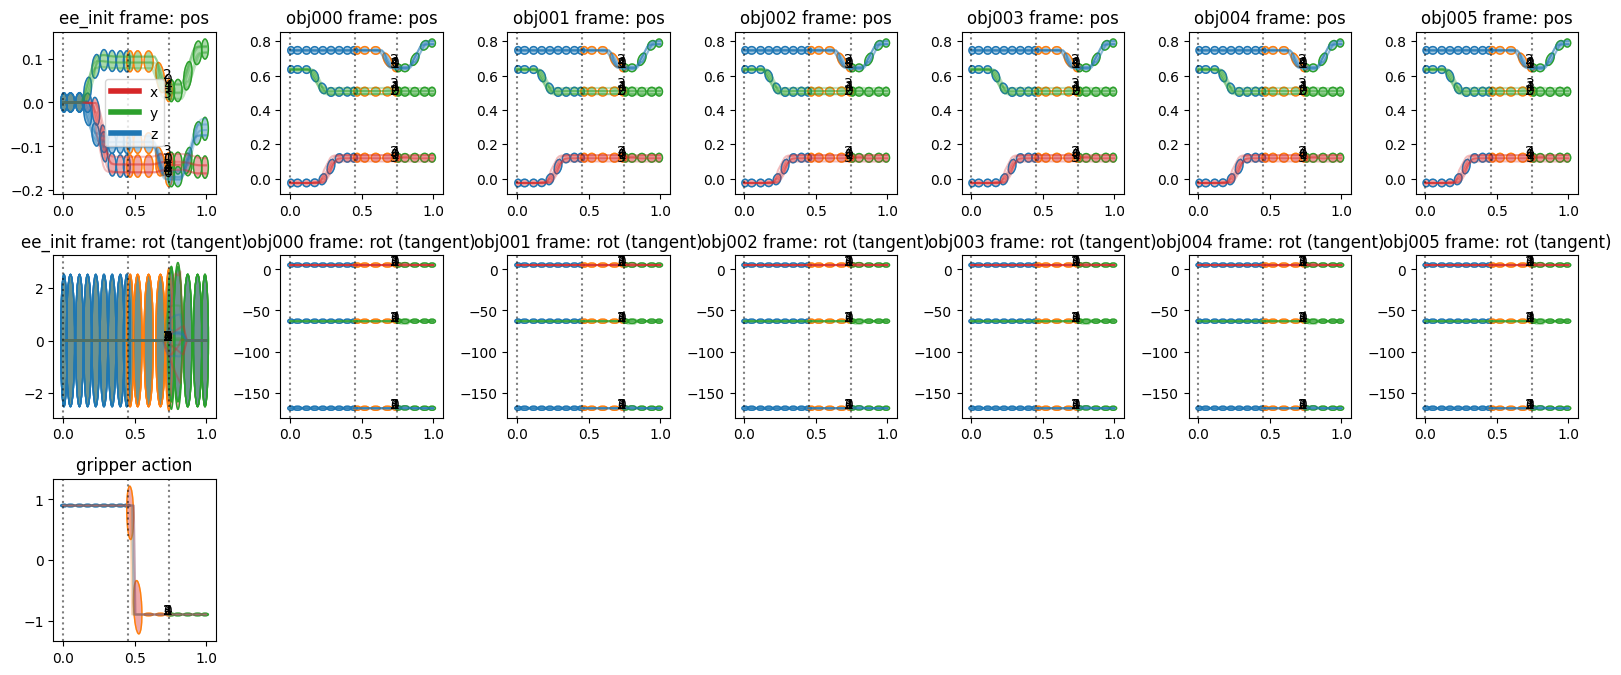

In [50]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [51]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-04-01 14:05:06.747 | INFO     |    Fitting AutoTPGMM


Fitting segments:   0%|          | 0/3 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

((array([[8.48e-001, 7.55e-001, 6.06e-001, ..., 3.06e-202, 2.93e-206,
          2.53e-210],
         [1.52e-001, 2.44e-001, 3.91e-001, ..., 1.40e-163, 9.70e-166,
          6.64e-168],
         [1.30e-004, 5.95e-004, 2.64e-003, ..., 2.04e-147, 2.43e-149,
          2.81e-151],
         ...,
         [2.13e-054, 2.59e-052, 3.05e-050, ..., 3.34e-003, 8.64e-004,
          2.16e-004],
         [8.68e-070, 2.88e-067, 9.24e-065, ..., 3.10e-001, 1.82e-001,
          1.03e-001],
         [1.33e-097, 6.23e-094, 2.69e-090, ..., 6.86e-001, 8.17e-001,
          8.97e-001]]),
  array([[1.00e+00, 9.99e-01, 9.99e-01, 9.99e-01, 6.06e-04, 2.09e-04,
          5.65e-05, 1.19e-05, 2.01e-06, 2.87e-07, 3.55e-08, 3.88e-09,
          3.77e-10, 3.25e-11, 2.46e-12, 1.62e-13, 9.19e-15, 2.62e-16,
          3.44e-19, 5.39e-29, 1.62e-37, 3.24e-48, 3.19e-54, 2.07e-57,
          6.33e-60, 2.55e-62, 1.00e+00, 9.99e-01, 3.44e-03, 1.67e-03,
          7.02e-04, 2.43e-04, 6.60e-05, 1.39e-05, 2.35e-06, 3.34e-07,
          4.

2025-04-01 14:05:14.691 | INFO     |    Did not specify time_based, deciding automatically.


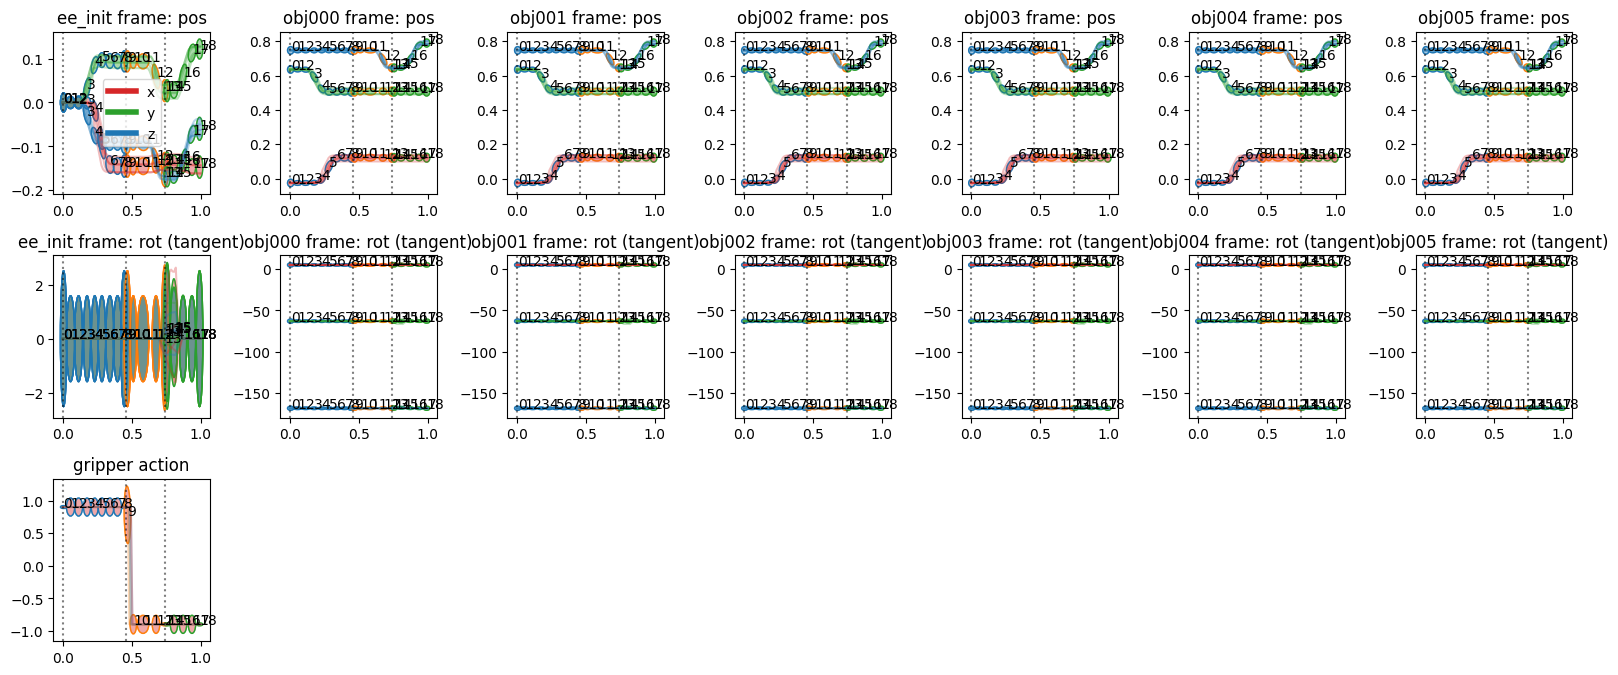

In [52]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

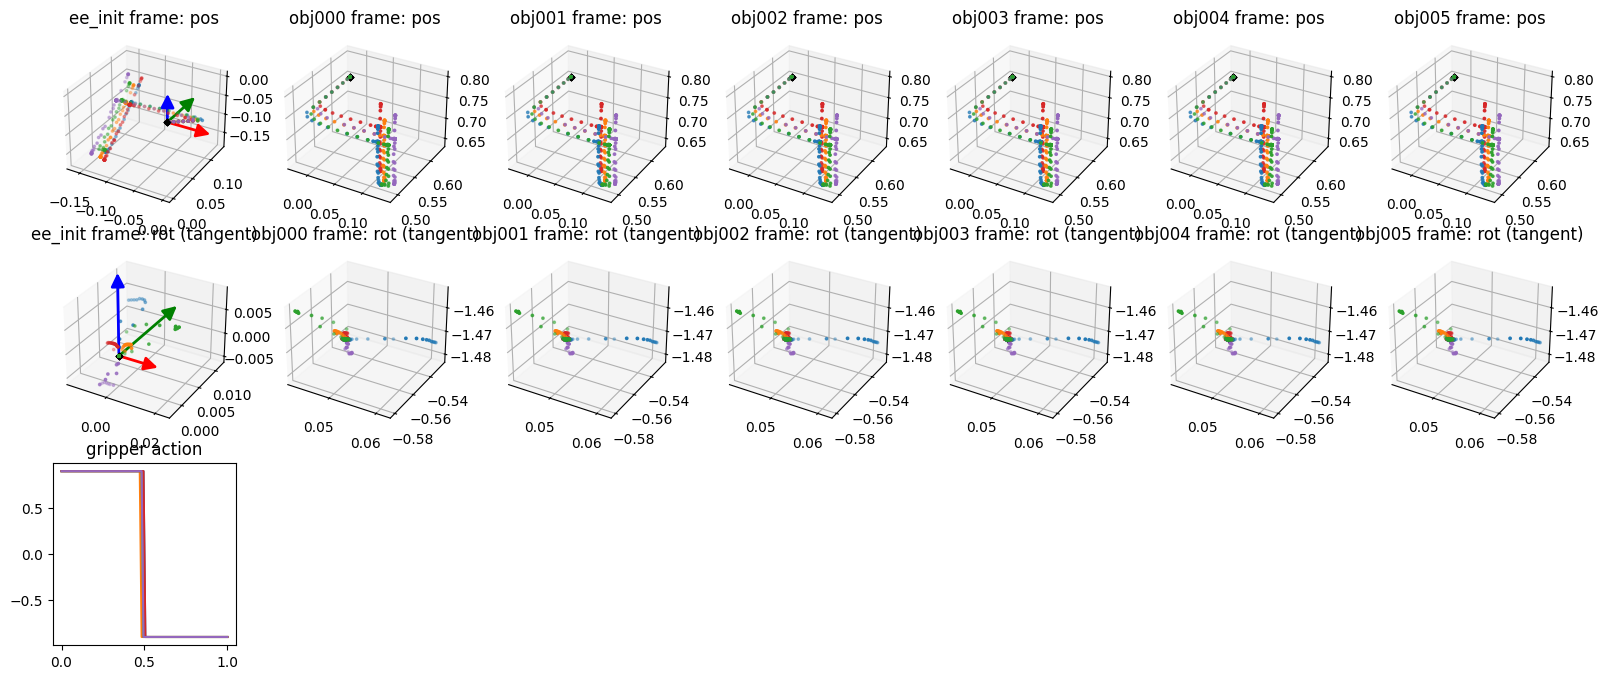

In [53]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

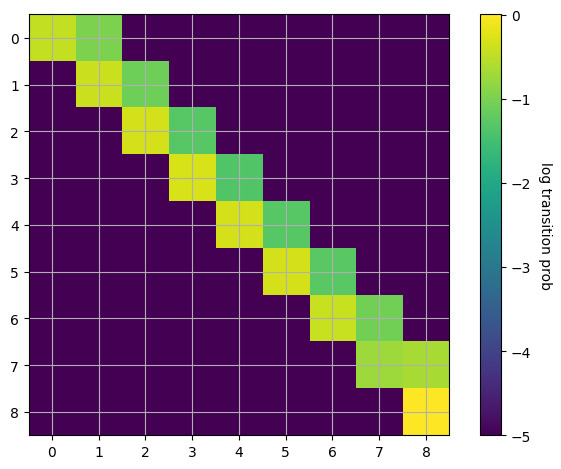

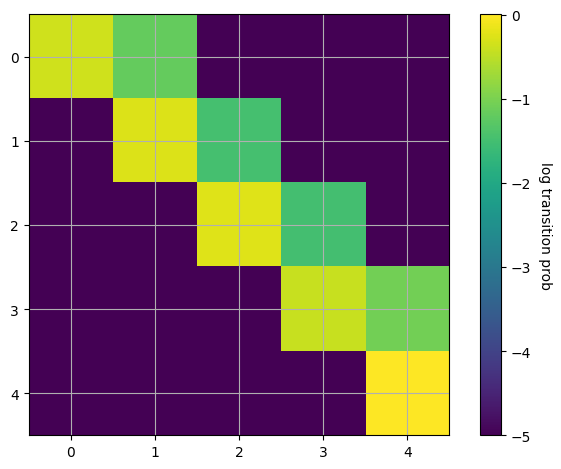

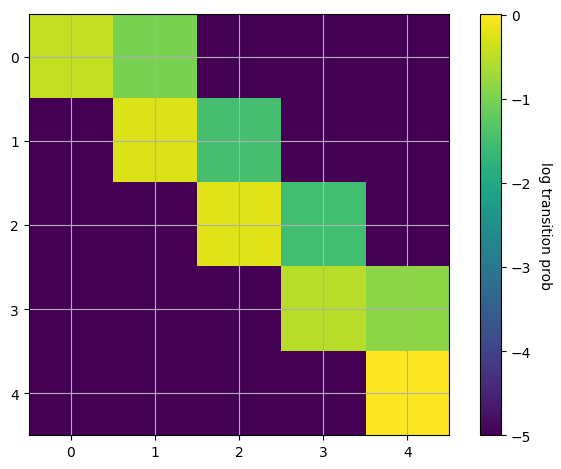

In [54]:
atpgmm.plot_hmm_transition_matrix()

In [55]:
atpgmm.to_disk(data_root / task / f'demos_gmm_policy-{tag}.pt')

In [56]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-04-01 14:05:33.115 | INFO     |    Caculated segment transition probabilities: (array([[1.]]), array([[1.]]))
2025-04-01 14:05:33.116 | INFO     |    Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-01 14:05:34.221 | INFO     |    Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-01 14:05:34.802 | INFO     |    Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

GMR:   0%|          | 0/5 [00:00<?, ?it/s]

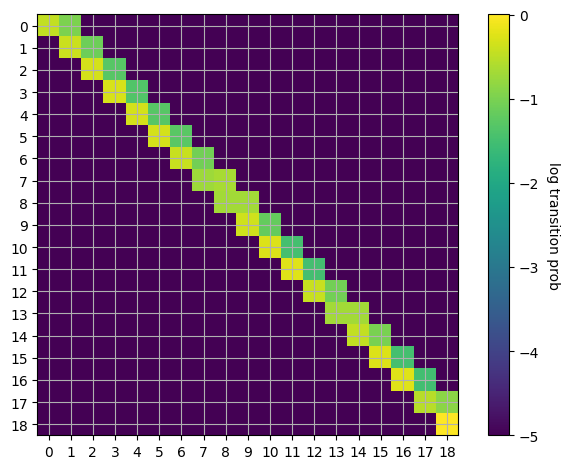

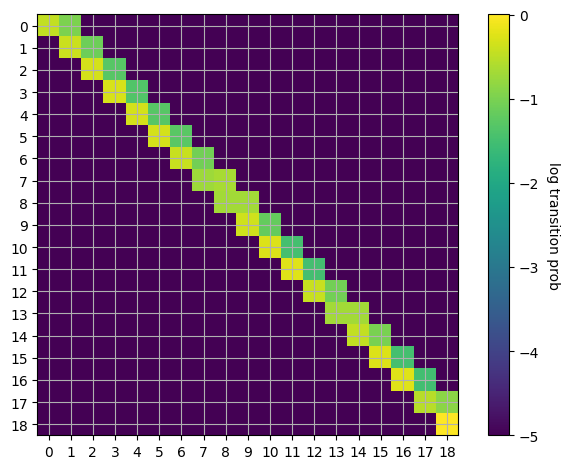

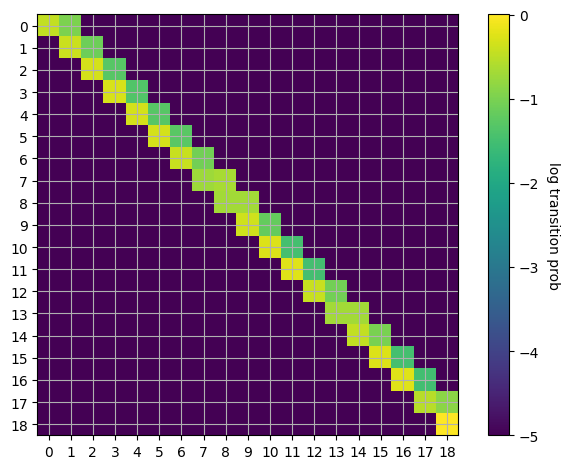

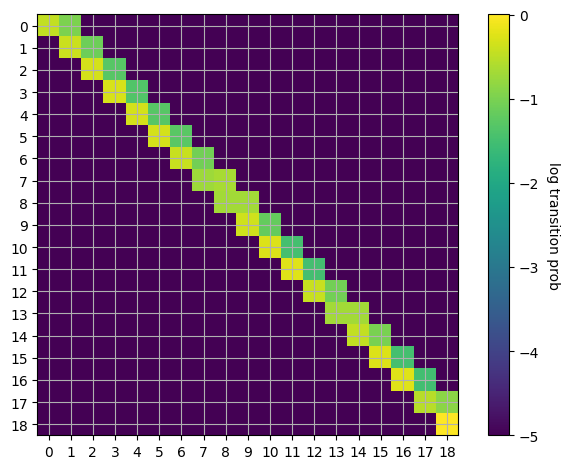

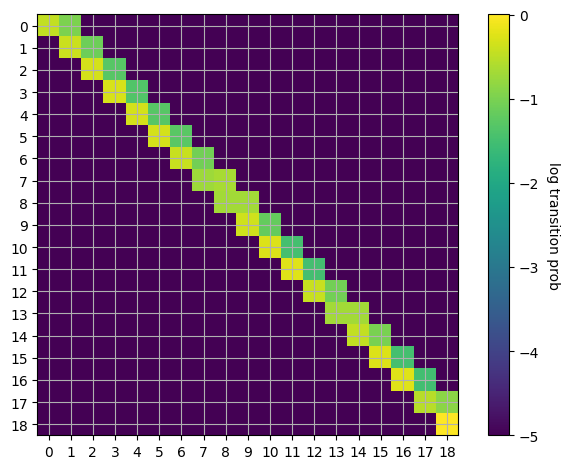

In [57]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

Marginal 0 with 10 components, 
used frames: [0 1 2 3 4 5 6]
Marginal 1 with 10 components, 
used frames: [0 1 2 3 4 5 6]
Marginal 2 with 10 components, 
used frames: [0 1 2 3 4 5 6]
Marginal 3 with 10 components, 
used frames: [0 1 2 3 4 5 6]
Marginal 4 with 10 components, 
used frames: [0 1 2 3 4 5 6]
2025-04-01 14:05:46.576 | INFO     |    Taking frame origins from demos.


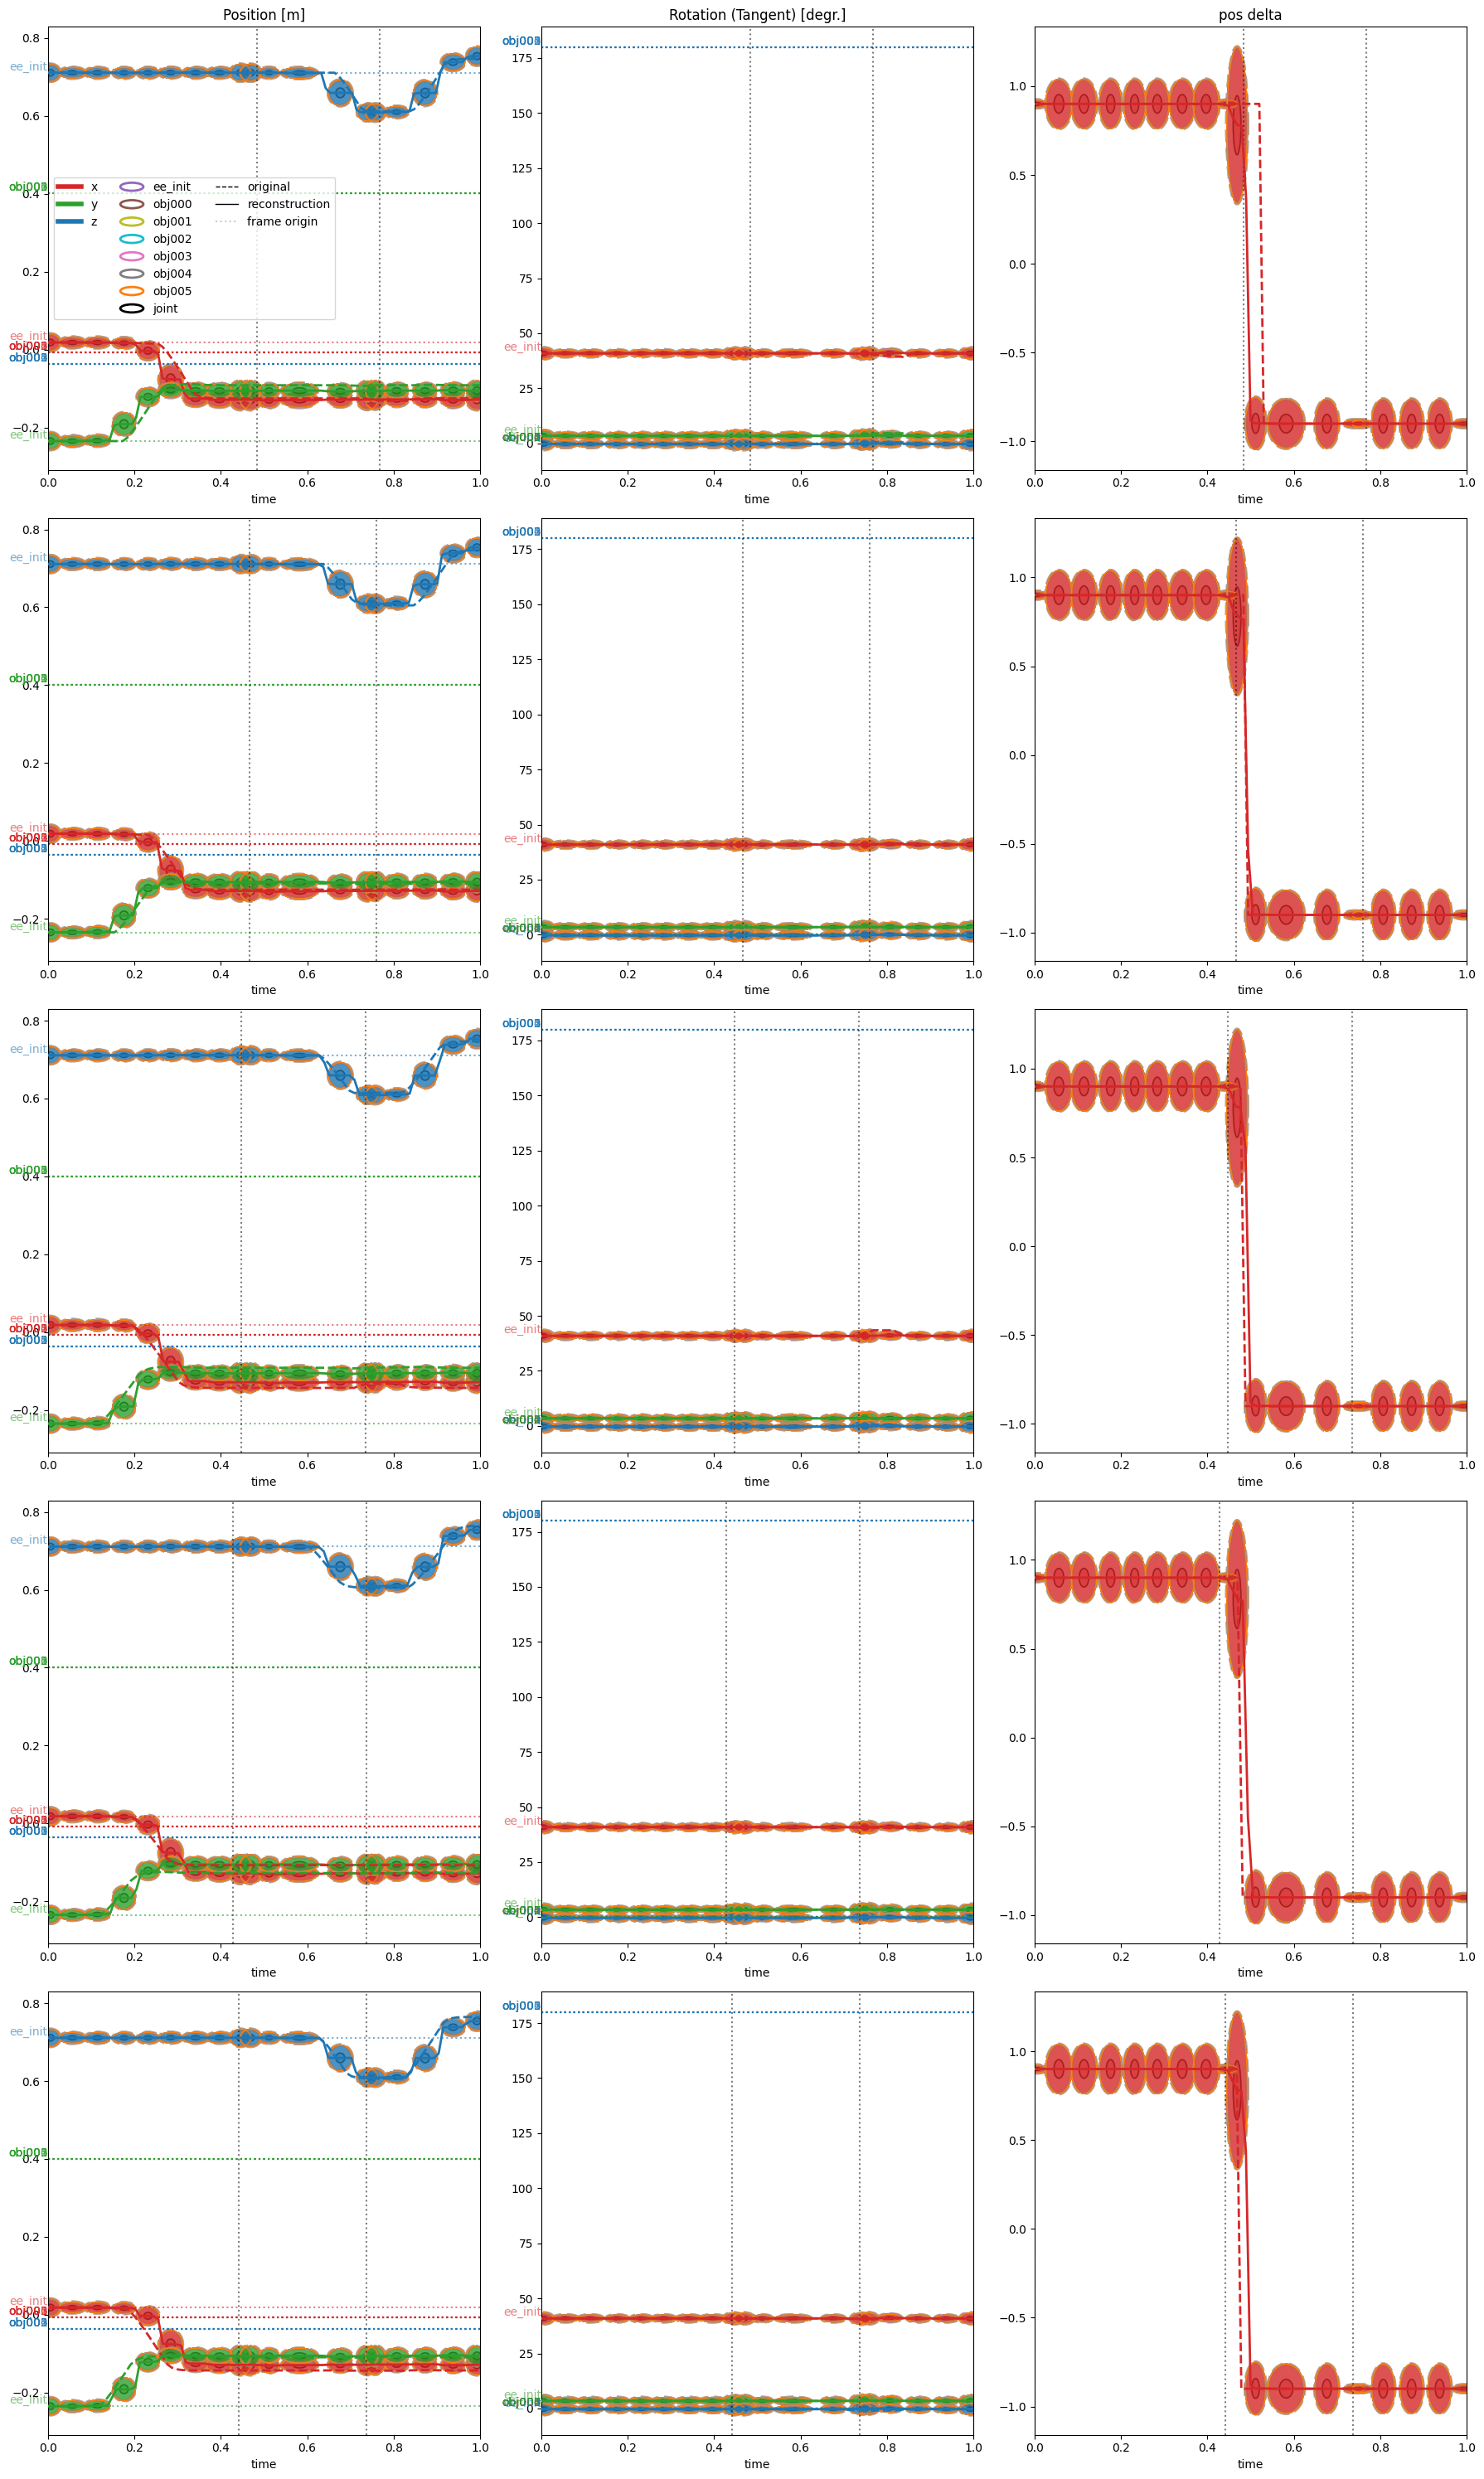

In [58]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container,
    cascaded_hmms,
    reconstructions,
    original_trajectories,
    plot_trajectories=True,
    plot_reconstructions=True,
    plot_gaussians=True,
    time_based=True,
    equal_aspect=False,
    per_segment=False,
)

In [59]:
atpgmm.plot_reconstructions(
    seg_trans_marginals,
    seg_joint_models,
    reconstructions,
    original_trajectories,
    plot_trajectories=True,
    plot_reconstructions=True,
    plot_gaussians=True,
    time_based=False,
    equal_aspect=True,
    per_segment=False,
)

Marginal 0 with 3 components, 
used frames: [0 1 2 3 4 5 6]
Marginal 1 with 3 components, 
used frames: [0 1 2 3 4 5 6]
Marginal 2 with 3 components, 
used frames: [0 1 2 3 4 5 6]
Marginal 3 with 3 components, 
used frames: [0 1 2 3 4 5 6]
Marginal 4 with 3 components, 
used frames: [0 1 2 3 4 5 6]


IndexError: tuple index out of range